In [6]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
# !pip install keras
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt


In [7]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)


4423680/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1)


In [8]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [9]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [10]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [11]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [12]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [13]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [14]:
discriminator = define_discriminator()

In [15]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [16]:
generator = define_generator(100)

In [17]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [18]:
gan_model = define_gan(generator, discriminator)


In [19]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

>1, dr[0.464,0.797], df[0.699,0.031], g[0.690,0.859]
>2, dr[0.039,1.000], df[0.710,0.000], g[0.680,1.000]
>3, dr[0.016,1.000], df[0.720,0.000], g[0.671,1.000]
>4, dr[0.009,1.000], df[0.736,0.000], g[0.660,1.000]
>5, dr[0.010,1.000], df[0.751,0.000], g[0.645,1.000]
>6, dr[0.007,1.000], df[0.778,0.000], g[0.634,1.000]
>7, dr[0.015,1.000], df[0.798,0.000], g[0.624,1.000]
>8, dr[0.007,1.000], df[0.810,0.000], g[0.620,1.000]
>9, dr[0.013,1.000], df[0.812,0.000], g[0.627,1.000]
>10, dr[0.015,1.000], df[0.803,0.000], g[0.658,0.906]
>11, dr[0.021,1.000], df[0.754,0.016], g[0.715,0.250]
>12, dr[0.023,1.000], df[0.711,0.328], g[0.772,0.016]
>13, dr[0.035,1.000], df[0.682,0.656], g[0.810,0.000]
>14, dr[0.026,1.000], df[0.653,0.906], g[0.847,0.000]
>15, dr[0.052,1.000], df[0.665,0.797], g[0.816,0.000]
>16, dr[0.016,1.000], df[0.677,0.688], g[0.823,0.000]
>17, dr[0.023,1.000], df[0.666,0.812], g[0.822,0.000]
>18, dr[0.019,1.000], df[0.662,0.828], g[0.826,0.000]
>19, dr[0.033,1.000], df[0.665,0.859]

<ipython-input-11-40f70dbe2455>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(10, 10, 1 + i)


>Saved: model_1874.h5
>1875, dr[0.463,0.703], df[0.384,0.844], g[2.066,0.000]
>1876, dr[0.531,0.656], df[0.318,0.938], g[2.029,0.016]
>1877, dr[0.472,0.688], df[0.356,0.906], g[2.262,0.016]
>1878, dr[0.417,0.766], df[0.334,0.891], g[2.160,0.016]
>1879, dr[0.463,0.703], df[0.308,0.969], g[2.203,0.000]
>1880, dr[0.413,0.734], df[0.263,0.969], g[1.998,0.016]
>1881, dr[0.485,0.734], df[0.521,0.812], g[1.951,0.047]
>1882, dr[0.467,0.719], df[0.308,0.891], g[2.237,0.016]
>1883, dr[0.431,0.781], df[0.471,0.828], g[2.356,0.000]
>1884, dr[0.432,0.719], df[0.227,0.984], g[2.239,0.016]
>1885, dr[0.408,0.781], df[0.323,0.953], g[2.113,0.016]
>1886, dr[0.308,0.875], df[0.505,0.797], g[2.732,0.016]
>1887, dr[0.504,0.688], df[0.240,0.938], g[2.580,0.016]
>1888, dr[0.553,0.719], df[0.369,0.891], g[2.143,0.031]
>1889, dr[0.241,0.891], df[0.328,0.938], g[2.427,0.000]
>1890, dr[0.447,0.688], df[0.300,0.922], g[2.230,0.016]
>1891, dr[0.403,0.750], df[0.335,0.938], g[2.296,0.062]
>1892, dr[0.341,0.828], df

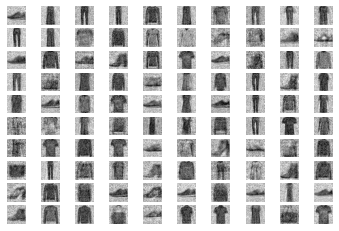

In [20]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

<ipython-input-12-16f5f34348f4>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)


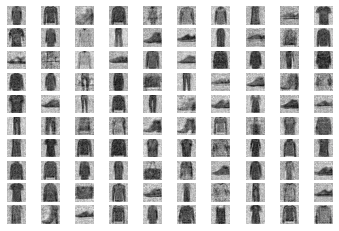

In [21]:
model = load_model('model_18740.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)